In [121]:
!pip install keras
!pip install visualkeras

In [122]:
from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding, Activation
from keras.layers import LSTM
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

In [123]:
df_reddit = pd.read_csv('Reddit_Data.csv')
df_twitter = pd.read_csv('Twitter_Data.csv')

In [124]:
df_twitter.rename(columns = {'clean_text':'clean_comment'}, inplace = True)

In [125]:
df_twitter.shape,  df_reddit.shape

((162980, 2), (37249, 2))

In [126]:
df = df_reddit.append(df_twitter).reset_index()

C:\Users\IDEA Lab\AppData\Local\Temp\ipykernel_11360\683143655.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_reddit.append(df_twitter).reset_index()


<AxesSubplot: title={'center': 'String Length Distribution'}, ylabel='Frequency'>

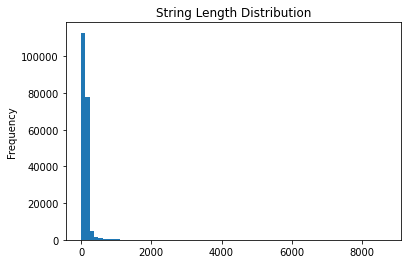

In [127]:
pd.DataFrame(df['clean_comment'].str.len())['clean_comment'].plot(
    kind='hist',
    bins=70,
    xlabel='String length',
    ylabel='count',
    title='String Length Distribution')

<AxesSubplot: title={'center': 'Word Count Distribution'}, ylabel='Frequency'>

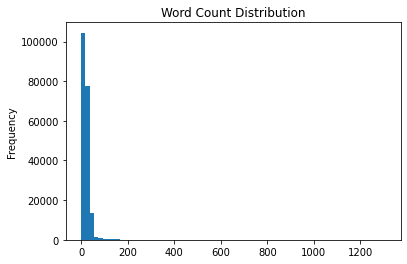

In [128]:
df['word_count'] = df['clean_comment'].str.split().str.len()
df['word_count'].plot(
    kind='hist',
    bins=70,
    xlabel='String length',
    ylabel='count',
    title='Word Count Distribution')

<AxesSubplot: title={'center': 'Top 20 words Combined'}, xlabel='ReviewText', ylabel='Count'>

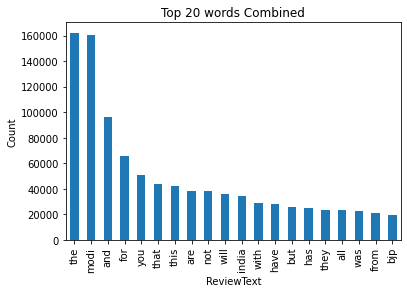

In [129]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df['clean_comment'].dropna().tolist(), 20)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 20 words Combined')

In [130]:
def rename(val):
    if val == -1:
        return "Negative"
    elif val == 0:
        return "Neutral"
    elif val ==1:
        return "Positive"

In [131]:
df['category'] = df['category'].apply(rename)

df = df.sample(frac=1)

In [132]:
df[["clean_comment", "category"]].describe(include='all')

,clean_comment,category
count,200125,200222
unique,199715,3
top,,Positive
freq,116,88080


In [133]:
df.isnull().sum()

index              0
clean_comment    104
category           7
word_count       104
dtype: int64

In [134]:
df = df.dropna()
df.shape

(200118, 4)

In [135]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [136]:
#remove 
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',str(text))



def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text


def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word


def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string


def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)
                     


def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)


def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)


def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)



def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)



def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)


def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)


def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)


def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text


def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

def stemming(text):
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text


In [137]:
def clean_text(text):
    
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)

    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    text = remove_all_punct(text)
    text = remove_punct(text)
    text = lemmatization(text)
    text = text.lower()

    return text

In [138]:
df["clean_comment"] = df["clean_comment"].apply(clean_text)

In [139]:
g=[]
for i in df['clean_comment']:
    g.append(i)

In [140]:
maxl = max([len(s) for s in g])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 8376


In [141]:
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['clean_comment'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 116600 unique tokens.


In [142]:
maxl = 1000
X = tokenizer.texts_to_sequences(df['clean_comment'].values)
X = pad_sequences(X, maxlen=maxl)

In [143]:
Y = pd.get_dummies(df['category'],columns=df["category"]).values

In [144]:
import tensorflow as tf

adam = optimizers.Adam(lr=0.001)
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(1000,128,input_length=maxl))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

C:\Users\IDEA Lab\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [145]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 128)         128000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 1000, 128)        0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 259,971
Trainable params: 259,971
Non-trainable params: 0
_________________________________________________________________


In [146]:
from sklearn.model_selection import train_test_split
train_x, test_x , train_y, test_y = train_test_split(X, Y, test_size=.3)

In [147]:
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(train_x, train_y, epochs=3, batch_size=256)

Epoch 1/3
548/548 [==============================] - 2783s 5s/step - loss: 0.5964 - accuracy: 0.7686
Epoch 2/3
548/548 [==============================] - 2762s 5s/step - loss: 0.5006 - accuracy: 0.8202
Epoch 3/3
548/548 [==============================] - 2783s 5s/step - loss: 0.4842 - accuracy: 0.8239


In [148]:
model.save('./my_model.h5')

In [150]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(history, f)


INFO:tensorflow:Assets written to: ram://30758e18-73d2-4a00-86c6-1dc3e8572009/assets


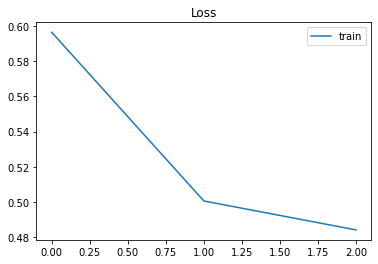

In [151]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show();

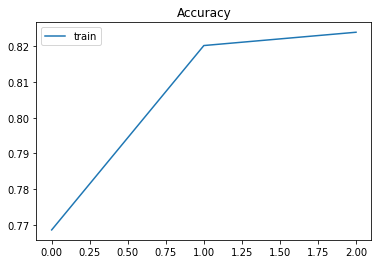

In [153]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show();

1877/1877 [==============================] - 1282s 683ms/step


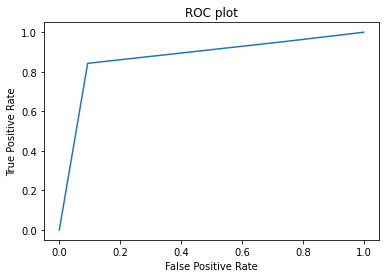

In [155]:
from sklearn.metrics import roc_curve, plot_roc_curve
fpr, tpr, _ = roc_curve(test_y.argmax(axis=1),model.predict(test_x).argmax(axis=1), pos_label=2)
plt.plot(fpr,tpr)
plt.title("ROC plot")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

1877/1877 [==============================] - 1323s 704ms/step


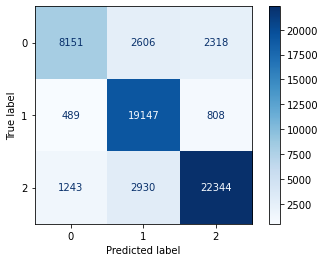

In [157]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
cm_rm_2 = confusion_matrix((test_y).argmax(axis=1),model.predict(test_x).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()